## Burger's Equation

### (1) Problem Description
\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in [-1,1],\ t\in(0,1] 
\end{equation}
We set $\nu=0.1/\pi$ and consider the periodic boundary condition here, i.e.:
$$
u(-1, t) = u(1, t)=0,\quad t\in(0,1]
$$
The initial condition is $u(x,t=0)=a(x)$. Our goal is to learn a neural operator to predict the solution $u$ at $t=1$ given an initial condition $a(x)$, i.e.:
$$
\mathcal{G}: a(x) \rightarrow u(x,t=1)
$$

### (2) The Deep Generative Neural Operator (DGNO)
[Paper: DGNO: A Novel Physics-aware Neural Operator for Solving Forward and Inverse PDE Problems based on Deep, Generative Probabilistic Modeling](https://arxiv.org/pdf/2502.06250)

### (2.1) Prepare data

The shape of x_train: torch.Size([1000, 128, 1])
The shape of a_train: torch.Size([1000, 128, 1])
The shape of gridxt_train: torch.Size([12928, 2])
The shape of x_test: torch.Size([200, 128, 1])
The shape of a_test: torch.Size([200, 128, 1])
The shape of u_test: torch.Size([200, 12928, 1])
The shape of uT_train: torch.Size([200, 128, 1])
The shape of gridxt_test: torch.Size([12928, 2])
************************************
The shape of xt_init: torch.Size([128, 2])
The shape of xt_end: torch.Size([128, 2])


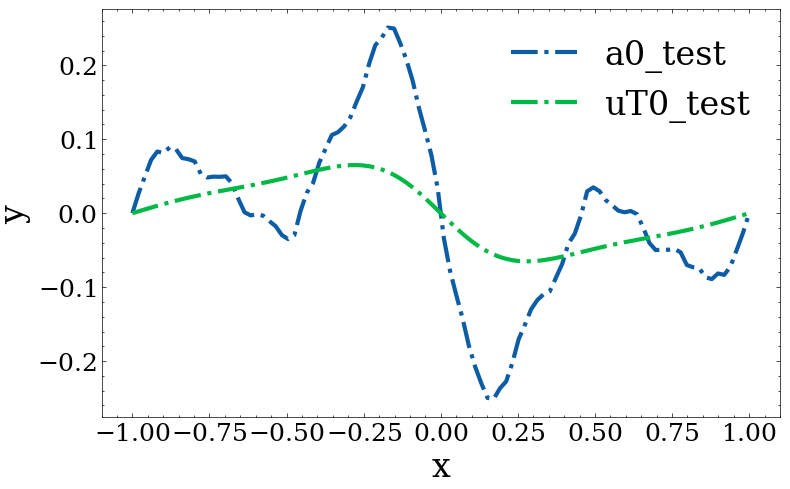

In [1]:
import sys 
sys.path.append("..")
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 10086 
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32

######################################
# Load training and testing data
######################################
from Utils.utils import *
#
def get_data(data, dtype):
    a = np2tensor(np.array(data["u0"]).T, dtype)
    u = np2tensor(np.array(data["u_sol"]).T, dtype)
    uT = u[:,-1,:]
    #
    x_mesh = np.array(data['x_mesh']).T
    t_mesh = np.array(data['t_mesh']).T
    X, T = np.meshgrid(x_mesh, t_mesh)
    mesh = np2tensor(np.vstack([X.ravel(), T.ravel()]).T, dtype)
    grid_xt = mesh.reshape(-1, 2)
    #
    ndata = a.shape[0]
    x = np2tensor(x_mesh).reshape(1, -1, 1).repeat(ndata,1,1)
    a = a.reshape(ndata, -1, 1)
    u = u.reshape(ndata, -1, 1)
    uT = uT.reshape(ndata, -1, 1)
    
    return a, u, uT, x, grid_xt
#
data_train = h5py.File('./dataset/viscid_train.mat', 'r')
data_test = h5py.File('./dataset/viscid_test_in.mat', 'r')
a_train, u_train, uT_train, x_train, gridxt_train = get_data(data_train, dtype)
a_test, u_test, uT_test, x_test, gridxt_test = get_data(data_test, dtype)
#
print('The shape of x_train:', x_train.shape)
print('The shape of a_train:', a_train.shape)
print('The shape of gridxt_train:', gridxt_train.shape)
#
print('The shape of x_test:', x_test.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of uT_train:', uT_test.shape)
print('The shape of gridxt_test:', gridxt_test.shape)

###################################### initial points
from Utils.GenPoints_Time import Point1D
pointGen = Point1D(x_lb=[-1.], x_ub=[1.], dataType=dtype, random_seed=random_seed)
xt_init = pointGen.init_point(num_sample=a_test.shape[1], t_stamp=[0.], method='mesh')
xt_end = pointGen.init_point(num_sample=uT_test.shape[1], t_stamp=[1.], method='mesh')
print('************************************')
print('The shape of xt_init:', xt_init.shape)
print('The shape of xt_end:', xt_end.shape)

########################################
from Utils.PlotFigure import Plot
inx = 0
Plot.show_1d_list(x_test[inx], [a_test[inx], uT_test[inx]], ['a0_test', 'uT0_test'], lb =-1.)

### (2.2) Define the loss class

In [2]:
import torch.nn as nn
from torch.autograd import grad, Variable
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN

###############################
# The test function
###############################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=1, n_mesh_or_grid=10, dataType=dtype).get_testFun()
print('The shape of int_grid', int_grid.shape, 'The shape of phi:', phi.shape)

######################################
## The mollifier (to satisfy the boundary condition)
######################################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, xt):
        '''The mollifer
        Input:
            u: size(n_batch, mesh_size)
            xt: size(n_batch, mesh_size, 2)
        Output:
            u: size(n_batch, mesh_size, 1)
        '''
        x= xt[...,0]
        u = u * torch.sin(np.pi*x/2. + np.pi/2.)
        return u.unsqueeze(-1)

##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_enc = solver.model_dict['enc']
        self.model_u = solver.model_dict['u']
        self.mollifer = mollifer()
        ######################## 
        self.n_grid = int_grid.shape[0]
        self.int_grid = int_grid.to(self.device)
        self.v = phi.to(self.device)
        self.dv_dr = dphi_dr.to(self.device)
        
    def Loss_pde(self, a_batch, nc=100, lamda=0.1/torch.pi):
        ''' 
        Input:
            a_batch: size(n_batch, n_mesh, in_channel)
        '''
        beta = self.model_enc(a_batch)
        n_batch = a_batch.shape[0]
        # ################################## 
        # # # xc:size(nc, 1, 1), tc:size(nc, 1, 1) R:size(nc, 1, 1)
        xc, tc, R = pointGen.weight_centers(n_center=1, nt=nc, Rmax=1e-4, Rmin=1e-4, method='hypercube')
        xc, tc, R = xc.to(self.device), tc.to(self.device), R.to(self.device)
        # size(nc, n_grid, 1) -> (nc*n_grid, 1)
        x = (self.int_grid * R + xc).reshape(-1, 1)
        t = tc.repeat(1, self.n_grid, 1).reshape(-1, 1)
        # size(nc*n_grid, 1) -> (n_batch, nc*n_grid, 2)
        x = Variable(x.repeat((n_batch,1,1)), requires_grad=True) 
        t = Variable(t.repeat((n_batch,1,1)), requires_grad=True)  
        xt = torch.cat([x,t], dim=-1)
        ##########################################
        v = self.v.repeat((nc,1,1)).reshape(-1,1)
        dv = (self.dv_dr / R).reshape(-1,1)
        ##########################################
        u = self.model_u(xt, beta)
        u = self.mollifer(u, xt)
        # du: size(n_batch, nc*n_grid, 2)
        du = grad(inputs=xt, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        dux, dut = du[...,0:1], du[...,1:2]
        ########################################### weawk residual
        # size(n_batch, nc*n_grid, 1) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        res0 = dut*v + u * dux * v + lamda * dux * dv
        res0 = torch.mean(res0.reshape(n_batch, nc, self.n_grid), dim=-1)
        ################################################
        res_sq = (res0)**2
        res_sq, indices = torch.sort(res_sq.flatten(), descending=True, dim=0)

        return self.solver.getLoss(res0, torch.zeros_like(res0)) + torch.sum( res_sq[0:100*25] )  

    def Loss_data(self, x, a, u):
        '''Note: u is not used for training
        '''
        n_batch = a.shape[0]
        beta = self.model_enc(a)
        ############### The initial condition
        xt = xt_init.repeat(n_batch, 1, 1).to(self.device)
        u_init = self.model_u(xt, beta)
        u_init = self.mollifer(u_init, xt)
        #
        loss_init = self.solver.getLoss(u_init, a)
        
        return loss_init
        
    def Error(self, x, a, u):
        '''
        '''
        n_batch = a.shape[0]
        beta = self.model_enc(a)
        ##################
        xt = gridxt_test.repeat(n_batch, 1, 1).to(self.device)
        u_pred = self.model_u(xt, beta)
        u_pred = self.mollifer(u_pred, xt)
        #
        error = self.solver.getError(u_pred, u)

        return error

######################################
# Steups of the model
######################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
netType = 'MultiONetBatch' 
beta_size = 64   
hidden_size = 100

# ####################################### The Encoder
from Networks.EncoderNet import EncoderFCNet
class Encoder(nn.Module):
    def __init__(self, layers_beta, act_beta, dtype=None):
        super(Encoder, self).__init__()
        self.encoder = EncoderFCNet(layers_beta, act_beta, dtype=dtype)
        
    def forward(self, feat):
        beta = nn.Tanh()(self.encoder(feat))
        return beta
#
layers_beta = [a_train.shape[1], 256, 128, 64, beta_size]
model_enc = Encoder(layers_beta, act_beta='SiLU', dtype=dtype).to(device)

###################################### The Decoder
trunk_layers, branch_layers = [hidden_size]*6, [hidden_size]*6
model_u = solver.getModel(x_in_size=2, beta_in_size=beta_size, 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk='Tanh_Sin', activation_branch='SiLU_Id',
                           netType=netType, sum_layers=5)

# ###############################
total_trainable_params_enc = sum(p.numel() for p in model_enc.parameters() if p.requires_grad)
print(f'{total_trainable_params_enc:,} training parameters.')
#
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')
#
print(f'{total_trainable_params_enc + total_trainable_params_u:,} total parameters')

The shape of int_grid torch.Size([10, 1]) The shape of phi: torch.Size([10, 1])
78,336 training parameters.
107,806 training parameters.
186,142 total parameters


### (2.3) training the model

In [3]:
model_dict = {'u':model_u, 'enc':model_enc}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', 
                   gamma=1/3, step_size=np.int32(10000/5))
solver.train(LossClass, a_train, u_train, x_train, a_test, u_test, x_test, 
             w_data=10000, w_pde=1000., batch_size=50, epochs=10000, epoch_show=50,
             **{'save_path':f'saved_models/DGNO_latent{beta_size}/'})

  0%|▎                                                     | 50/10000 [00:22<1:11:52,  2.31it/s]

Epoch:50 Time:22.7819, loss:5565.7598, loss_pde:0.1833, loss_data:0.5383
                l2_test:0.1808, lr:0.001


  1%|▌                                                    | 100/10000 [00:45<1:13:48,  2.24it/s]

Epoch:100 Time:45.4626, loss:4275.1043, loss_pde:0.1467, loss_data:0.4128
                l2_test:0.1254, lr:0.001


  2%|▊                                                    | 150/10000 [01:08<1:13:34,  2.23it/s]

Epoch:150 Time:68.3163, loss:3376.4273, loss_pde:0.1428, loss_data:0.3234
                l2_test:0.0870, lr:0.001


  2%|█                                                    | 200/10000 [01:30<1:11:18,  2.29it/s]

Epoch:200 Time:90.8922, loss:3313.0656, loss_pde:0.1481, loss_data:0.3165
                l2_test:0.0920, lr:0.001


  2%|█▎                                                   | 250/10000 [01:53<1:14:34,  2.18it/s]

Epoch:250 Time:113.5653, loss:2708.5004, loss_pde:0.1492, loss_data:0.2559
                l2_test:0.0753, lr:0.001


  3%|█▌                                                   | 300/10000 [02:15<1:13:34,  2.20it/s]

Epoch:300 Time:135.9571, loss:2651.6926, loss_pde:0.1398, loss_data:0.2512
                l2_test:0.0689, lr:0.001


  4%|█▊                                                   | 350/10000 [02:38<1:15:00,  2.14it/s]

Epoch:350 Time:158.7840, loss:2483.9756, loss_pde:0.2535, loss_data:0.2231
                l2_test:0.0734, lr:0.001


  4%|██                                                   | 400/10000 [03:01<1:13:11,  2.19it/s]

Epoch:400 Time:181.7305, loss:2298.0453, loss_pde:0.1611, loss_data:0.2137
                l2_test:0.0582, lr:0.001


  4%|██▍                                                  | 450/10000 [03:24<1:08:45,  2.31it/s]

Epoch:450 Time:204.3578, loss:2153.1828, loss_pde:0.1130, loss_data:0.2040
                l2_test:0.0531, lr:0.001


  5%|██▋                                                  | 500/10000 [03:46<1:13:36,  2.15it/s]

Epoch:500 Time:226.7674, loss:2002.9867, loss_pde:0.1634, loss_data:0.1840
                l2_test:0.0546, lr:0.001


  6%|██▉                                                  | 550/10000 [04:09<1:13:57,  2.13it/s]

Epoch:550 Time:249.7352, loss:2020.7516, loss_pde:0.1743, loss_data:0.1846
                l2_test:0.0619, lr:0.001


  6%|███▏                                                 | 600/10000 [04:32<1:06:14,  2.36it/s]

Epoch:600 Time:272.3687, loss:2024.1730, loss_pde:0.1630, loss_data:0.1861
                l2_test:0.0561, lr:0.001


  6%|███▍                                                 | 650/10000 [04:54<1:10:25,  2.21it/s]

Epoch:650 Time:294.8209, loss:1972.8223, loss_pde:0.2471, loss_data:0.1726
                l2_test:0.0652, lr:0.001


  7%|███▋                                                 | 700/10000 [05:17<1:13:25,  2.11it/s]

Epoch:700 Time:317.7504, loss:1688.1537, loss_pde:0.1378, loss_data:0.1550
                l2_test:0.0430, lr:0.001


  8%|███▉                                                 | 750/10000 [05:40<1:12:21,  2.13it/s]

Epoch:750 Time:340.2952, loss:1707.1457, loss_pde:0.1648, loss_data:0.1542
                l2_test:0.0559, lr:0.001


  8%|████▏                                                | 800/10000 [06:03<1:11:39,  2.14it/s]

Epoch:800 Time:363.3131, loss:1667.8174, loss_pde:0.1435, loss_data:0.1524
                l2_test:0.0501, lr:0.001


  8%|████▌                                                | 850/10000 [06:26<1:08:30,  2.23it/s]

Epoch:850 Time:386.2479, loss:1783.5750, loss_pde:0.2371, loss_data:0.1546
                l2_test:0.0590, lr:0.001


  9%|████▊                                                | 900/10000 [06:48<1:10:08,  2.16it/s]

Epoch:900 Time:408.7067, loss:1560.7821, loss_pde:0.1574, loss_data:0.1403
                l2_test:0.0472, lr:0.001


 10%|█████                                                | 950/10000 [07:11<1:11:36,  2.11it/s]

Epoch:950 Time:431.5820, loss:1638.8117, loss_pde:0.2239, loss_data:0.1415
                l2_test:0.0500, lr:0.001


 10%|█████▏                                              | 1000/10000 [07:33<1:04:57,  2.31it/s]

Epoch:1000 Time:453.8648, loss:1580.8888, loss_pde:0.2267, loss_data:0.1354
                l2_test:0.0561, lr:0.001


 10%|█████▍                                              | 1050/10000 [07:55<1:03:47,  2.34it/s]

Epoch:1050 Time:475.6811, loss:1638.4080, loss_pde:0.2365, loss_data:0.1402
                l2_test:0.0565, lr:0.001


 11%|█████▋                                              | 1100/10000 [08:17<1:06:14,  2.24it/s]

Epoch:1100 Time:497.9790, loss:1531.8507, loss_pde:0.2050, loss_data:0.1327
                l2_test:0.0535, lr:0.001


 12%|█████▉                                              | 1150/10000 [08:39<1:06:05,  2.23it/s]

Epoch:1150 Time:519.8157, loss:1394.5036, loss_pde:0.1532, loss_data:0.1241
                l2_test:0.0435, lr:0.001


 12%|██████▏                                             | 1200/10000 [09:02<1:06:16,  2.21it/s]

Epoch:1200 Time:542.3445, loss:1406.6603, loss_pde:0.1769, loss_data:0.1230
                l2_test:0.0548, lr:0.001


 12%|██████▌                                             | 1250/10000 [09:25<1:04:48,  2.25it/s]

Epoch:1250 Time:565.3911, loss:1475.8742, loss_pde:0.2359, loss_data:0.1240
                l2_test:0.0441, lr:0.001


 13%|██████▊                                             | 1300/10000 [09:47<1:07:28,  2.15it/s]

Epoch:1300 Time:587.6256, loss:1321.2903, loss_pde:0.1819, loss_data:0.1139
                l2_test:0.0488, lr:0.001


 14%|███████                                             | 1350/10000 [10:10<1:08:42,  2.10it/s]

Epoch:1350 Time:610.3873, loss:1353.5775, loss_pde:0.1782, loss_data:0.1175
                l2_test:0.0475, lr:0.001


 14%|███████▎                                            | 1400/10000 [10:33<1:04:45,  2.21it/s]

Epoch:1400 Time:633.2291, loss:1284.3105, loss_pde:0.1716, loss_data:0.1113
                l2_test:0.0485, lr:0.001


 14%|███████▌                                            | 1450/10000 [10:55<1:01:28,  2.32it/s]

Epoch:1450 Time:655.2295, loss:1328.1536, loss_pde:0.1981, loss_data:0.1130
                l2_test:0.0541, lr:0.001


 15%|███████▊                                            | 1500/10000 [11:17<1:07:05,  2.11it/s]

Epoch:1500 Time:677.9592, loss:1281.3632, loss_pde:0.1901, loss_data:0.1091
                l2_test:0.0501, lr:0.001


 16%|████████                                            | 1550/10000 [11:41<1:04:25,  2.19it/s]

Epoch:1550 Time:701.0277, loss:1233.7915, loss_pde:0.1745, loss_data:0.1059
                l2_test:0.0392, lr:0.001


 16%|████████▎                                           | 1600/10000 [12:03<1:02:17,  2.25it/s]

Epoch:1600 Time:723.6120, loss:1241.5908, loss_pde:0.1874, loss_data:0.1054
                l2_test:0.0474, lr:0.001


 16%|████████▌                                           | 1650/10000 [12:26<1:06:18,  2.10it/s]

Epoch:1650 Time:746.6490, loss:1298.1455, loss_pde:0.2134, loss_data:0.1085
                l2_test:0.0464, lr:0.001


 17%|████████▊                                           | 1700/10000 [12:49<1:01:11,  2.26it/s]

Epoch:1700 Time:769.5451, loss:1302.9172, loss_pde:0.1910, loss_data:0.1112
                l2_test:0.0453, lr:0.001


 18%|█████████                                           | 1750/10000 [13:11<1:01:17,  2.24it/s]

Epoch:1750 Time:791.8552, loss:1234.7251, loss_pde:0.1808, loss_data:0.1054
                l2_test:0.0446, lr:0.001


 18%|█████████▎                                          | 1800/10000 [13:34<1:02:38,  2.18it/s]

Epoch:1800 Time:814.3994, loss:1212.1970, loss_pde:0.1759, loss_data:0.1036
                l2_test:0.0445, lr:0.001


 18%|█████████▌                                          | 1850/10000 [13:57<1:02:55,  2.16it/s]

Epoch:1850 Time:837.6799, loss:1202.0521, loss_pde:0.1974, loss_data:0.1005
                l2_test:0.0392, lr:0.001


 19%|█████████▉                                          | 1900/10000 [14:20<1:02:36,  2.16it/s]

Epoch:1900 Time:860.6683, loss:1329.5518, loss_pde:0.2322, loss_data:0.1097
                l2_test:0.0479, lr:0.001


 20%|██████████▏                                         | 1950/10000 [14:42<1:00:27,  2.22it/s]

Epoch:1950 Time:882.9382, loss:1178.2090, loss_pde:0.1852, loss_data:0.0993
                l2_test:0.0432, lr:0.001


 20%|██████████▍                                         | 2000/10000 [15:05<1:01:05,  2.18it/s]

Epoch:2000 Time:905.4354, loss:1201.7020, loss_pde:0.2033, loss_data:0.0998
                l2_test:0.0441, lr:0.0003333333333333333


 20%|███████████                                           | 2050/10000 [15:28<57:17,  2.31it/s]

Epoch:2050 Time:928.0254, loss:880.4190, loss_pde:0.0678, loss_data:0.0813
                l2_test:0.0224, lr:0.0003333333333333333


 21%|██████████▉                                         | 2100/10000 [15:50<1:01:38,  2.14it/s]

Epoch:2100 Time:950.4995, loss:889.1436, loss_pde:0.0756, loss_data:0.0814
                l2_test:0.0247, lr:0.0003333333333333333


 22%|███████████▌                                          | 2150/10000 [16:12<56:31,  2.31it/s]

Epoch:2150 Time:972.9592, loss:885.1971, loss_pde:0.0931, loss_data:0.0792
                l2_test:0.0268, lr:0.0003333333333333333


 22%|███████████▉                                          | 2200/10000 [16:35<58:43,  2.21it/s]

Epoch:2200 Time:995.8628, loss:865.6747, loss_pde:0.0843, loss_data:0.0781
                l2_test:0.0242, lr:0.0003333333333333333


 22%|████████████▏                                         | 2250/10000 [16:57<56:39,  2.28it/s]

Epoch:2250 Time:1017.8018, loss:830.4352, loss_pde:0.0744, loss_data:0.0756
                l2_test:0.0222, lr:0.0003333333333333333


 23%|████████████▍                                         | 2300/10000 [17:20<57:52,  2.22it/s]

Epoch:2300 Time:1040.4833, loss:837.5863, loss_pde:0.0791, loss_data:0.0759
                l2_test:0.0226, lr:0.0003333333333333333


 24%|████████████▏                                       | 2350/10000 [17:42<1:00:41,  2.10it/s]

Epoch:2350 Time:1062.7982, loss:826.7357, loss_pde:0.0727, loss_data:0.0754
                l2_test:0.0228, lr:0.0003333333333333333


 24%|████████████▉                                         | 2400/10000 [18:05<56:57,  2.22it/s]

Epoch:2400 Time:1085.6071, loss:843.6021, loss_pde:0.1003, loss_data:0.0743
                l2_test:0.0262, lr:0.0003333333333333333


 24%|█████████████▏                                        | 2450/10000 [18:28<56:03,  2.24it/s]

Epoch:2450 Time:1108.2453, loss:789.7781, loss_pde:0.0780, loss_data:0.0712
                l2_test:0.0224, lr:0.0003333333333333333


 25%|█████████████▌                                        | 2500/10000 [18:51<58:23,  2.14it/s]

Epoch:2500 Time:1131.1111, loss:807.7208, loss_pde:0.0870, loss_data:0.0721
                l2_test:0.0238, lr:0.0003333333333333333


 26%|█████████████▊                                        | 2550/10000 [19:14<58:15,  2.13it/s]

Epoch:2550 Time:1154.3705, loss:784.9276, loss_pde:0.0752, loss_data:0.0710
                l2_test:0.0219, lr:0.0003333333333333333


 26%|██████████████                                        | 2600/10000 [19:36<55:32,  2.22it/s]

Epoch:2600 Time:1176.7130, loss:869.3719, loss_pde:0.1069, loss_data:0.0762
                l2_test:0.0256, lr:0.0003333333333333333


 26%|██████████████▎                                       | 2650/10000 [19:59<58:33,  2.09it/s]

Epoch:2650 Time:1199.3332, loss:781.4949, loss_pde:0.0758, loss_data:0.0706
                l2_test:0.0211, lr:0.0003333333333333333


 27%|██████████████▌                                       | 2700/10000 [20:21<54:38,  2.23it/s]

Epoch:2700 Time:1221.8334, loss:781.1551, loss_pde:0.0756, loss_data:0.0706
                l2_test:0.0215, lr:0.0003333333333333333


 28%|██████████████▊                                       | 2750/10000 [20:44<55:27,  2.18it/s]

Epoch:2750 Time:1244.9330, loss:814.5791, loss_pde:0.0921, loss_data:0.0722
                l2_test:0.0252, lr:0.0003333333333333333


 28%|███████████████                                       | 2800/10000 [21:08<53:51,  2.23it/s]

Epoch:2800 Time:1268.0516, loss:771.1488, loss_pde:0.0750, loss_data:0.0696
                l2_test:0.0222, lr:0.0003333333333333333


 28%|███████████████▍                                      | 2850/10000 [21:30<52:11,  2.28it/s]

Epoch:2850 Time:1290.3238, loss:764.4517, loss_pde:0.0751, loss_data:0.0689
                l2_test:0.0199, lr:0.0003333333333333333


 29%|███████████████▋                                      | 2900/10000 [21:52<55:08,  2.15it/s]

Epoch:2900 Time:1312.9305, loss:790.6286, loss_pde:0.1016, loss_data:0.0689
                l2_test:0.0237, lr:0.0003333333333333333


 30%|███████████████▉                                      | 2950/10000 [22:15<53:38,  2.19it/s]

Epoch:2950 Time:1335.8913, loss:750.2500, loss_pde:0.0918, loss_data:0.0658
                l2_test:0.0242, lr:0.0003333333333333333


 30%|████████████████▏                                     | 3000/10000 [22:38<52:59,  2.20it/s]

Epoch:3000 Time:1358.2982, loss:764.3278, loss_pde:0.1005, loss_data:0.0664
                l2_test:0.0227, lr:0.0003333333333333333


 30%|████████████████▍                                     | 3050/10000 [23:00<52:01,  2.23it/s]

Epoch:3050 Time:1380.7403, loss:752.3375, loss_pde:0.0946, loss_data:0.0658
                l2_test:0.0236, lr:0.0003333333333333333


 31%|████████████████▋                                     | 3100/10000 [23:22<48:19,  2.38it/s]

Epoch:3100 Time:1402.8301, loss:780.7739, loss_pde:0.0973, loss_data:0.0684
                l2_test:0.0257, lr:0.0003333333333333333


 32%|█████████████████                                     | 3150/10000 [23:44<51:36,  2.21it/s]

Epoch:3150 Time:1424.6065, loss:740.8617, loss_pde:0.0839, loss_data:0.0657
                l2_test:0.0213, lr:0.0003333333333333333


 32%|█████████████████▎                                    | 3200/10000 [24:07<52:14,  2.17it/s]

Epoch:3200 Time:1447.0633, loss:732.8348, loss_pde:0.0758, loss_data:0.0657
                l2_test:0.0224, lr:0.0003333333333333333


 32%|█████████████████▌                                    | 3250/10000 [24:29<47:56,  2.35it/s]

Epoch:3250 Time:1469.2467, loss:735.8064, loss_pde:0.0865, loss_data:0.0649
                l2_test:0.0225, lr:0.0003333333333333333


 33%|█████████████████▊                                    | 3300/10000 [24:52<51:02,  2.19it/s]

Epoch:3300 Time:1492.0302, loss:735.2276, loss_pde:0.0813, loss_data:0.0654
                l2_test:0.0234, lr:0.0003333333333333333


 34%|██████████████████                                    | 3350/10000 [25:14<52:40,  2.10it/s]

Epoch:3350 Time:1514.8199, loss:769.8355, loss_pde:0.0990, loss_data:0.0671
                l2_test:0.0248, lr:0.0003333333333333333


 34%|██████████████████▎                                   | 3400/10000 [25:37<47:54,  2.30it/s]

Epoch:3400 Time:1537.1028, loss:715.0252, loss_pde:0.0765, loss_data:0.0639
                l2_test:0.0224, lr:0.0003333333333333333


 34%|██████████████████▋                                   | 3450/10000 [25:58<46:51,  2.33it/s]

Epoch:3450 Time:1558.8834, loss:725.5095, loss_pde:0.0817, loss_data:0.0644
                l2_test:0.0204, lr:0.0003333333333333333


 35%|██████████████████▉                                   | 3500/10000 [26:21<51:41,  2.10it/s]

Epoch:3500 Time:1581.6026, loss:722.6361, loss_pde:0.0819, loss_data:0.0641
                l2_test:0.0214, lr:0.0003333333333333333


 36%|███████████████████▏                                  | 3550/10000 [26:44<48:07,  2.23it/s]

Epoch:3550 Time:1604.3211, loss:723.7097, loss_pde:0.0787, loss_data:0.0645
                l2_test:0.0202, lr:0.0003333333333333333


 36%|███████████████████▍                                  | 3600/10000 [27:07<50:02,  2.13it/s]

Epoch:3600 Time:1627.2309, loss:713.3394, loss_pde:0.0781, loss_data:0.0635
                l2_test:0.0206, lr:0.0003333333333333333


 36%|███████████████████▋                                  | 3650/10000 [27:29<45:30,  2.33it/s]

Epoch:3650 Time:1649.2507, loss:728.9979, loss_pde:0.0912, loss_data:0.0638
                l2_test:0.0232, lr:0.0003333333333333333


 37%|███████████████████▉                                  | 3700/10000 [27:51<48:19,  2.17it/s]

Epoch:3700 Time:1671.7576, loss:718.8868, loss_pde:0.0850, loss_data:0.0634
                l2_test:0.0221, lr:0.0003333333333333333


 38%|████████████████████▎                                 | 3750/10000 [28:14<46:13,  2.25it/s]

Epoch:3750 Time:1694.0975, loss:713.8107, loss_pde:0.0839, loss_data:0.0630
                l2_test:0.0207, lr:0.0003333333333333333


 38%|████████████████████▌                                 | 3800/10000 [28:36<47:25,  2.18it/s]

Epoch:3800 Time:1716.8168, loss:705.9676, loss_pde:0.0886, loss_data:0.0617
                l2_test:0.0230, lr:0.0003333333333333333


 38%|████████████████████▊                                 | 3850/10000 [28:59<44:58,  2.28it/s]

Epoch:3850 Time:1739.5181, loss:711.9961, loss_pde:0.0916, loss_data:0.0620
                l2_test:0.0224, lr:0.0003333333333333333


 39%|█████████████████████                                 | 3900/10000 [29:21<47:30,  2.14it/s]

Epoch:3900 Time:1761.7543, loss:739.1584, loss_pde:0.1020, loss_data:0.0637
                l2_test:0.0245, lr:0.0003333333333333333


 40%|█████████████████████▎                                | 3950/10000 [29:44<47:22,  2.13it/s]

Epoch:3950 Time:1784.3477, loss:691.5663, loss_pde:0.0843, loss_data:0.0607
                l2_test:0.0208, lr:0.0003333333333333333


 40%|█████████████████████▌                                | 4000/10000 [30:06<42:53,  2.33it/s]

Epoch:4000 Time:1806.9452, loss:753.6256, loss_pde:0.1079, loss_data:0.0646
                l2_test:0.0233, lr:0.0001111111111111111


 40%|█████████████████████▊                                | 4050/10000 [30:29<44:15,  2.24it/s]

Epoch:4050 Time:1829.6872, loss:614.8446, loss_pde:0.0495, loss_data:0.0565
                l2_test:0.0148, lr:0.0001111111111111111


 41%|██████████████████████▏                               | 4100/10000 [30:52<43:15,  2.27it/s]

Epoch:4100 Time:1852.6475, loss:614.7469, loss_pde:0.0501, loss_data:0.0565
                l2_test:0.0151, lr:0.0001111111111111111


 42%|██████████████████████▍                               | 4150/10000 [31:15<42:43,  2.28it/s]

Epoch:4150 Time:1875.0109, loss:612.8248, loss_pde:0.0466, loss_data:0.0566
                l2_test:0.0146, lr:0.0001111111111111111


 42%|██████████████████████▋                               | 4200/10000 [31:37<45:09,  2.14it/s]

Epoch:4200 Time:1897.6816, loss:623.2338, loss_pde:0.0549, loss_data:0.0568
                l2_test:0.0156, lr:0.0001111111111111111


 42%|██████████████████████▉                               | 4250/10000 [32:00<47:08,  2.03it/s]

Epoch:4250 Time:1920.6824, loss:612.5583, loss_pde:0.0486, loss_data:0.0564
                l2_test:0.0148, lr:0.0001111111111111111


 43%|███████████████████████▏                              | 4300/10000 [32:23<41:54,  2.27it/s]

Epoch:4300 Time:1943.4378, loss:612.3171, loss_pde:0.0479, loss_data:0.0564
                l2_test:0.0148, lr:0.0001111111111111111


 44%|███████████████████████▍                              | 4350/10000 [32:46<44:39,  2.11it/s]

Epoch:4350 Time:1966.5368, loss:616.6219, loss_pde:0.0507, loss_data:0.0566
                l2_test:0.0146, lr:0.0001111111111111111


 44%|███████████████████████▊                              | 4400/10000 [33:09<41:56,  2.23it/s]

Epoch:4400 Time:1989.2063, loss:611.0500, loss_pde:0.0481, loss_data:0.0563
                l2_test:0.0153, lr:0.0001111111111111111


 44%|████████████████████████                              | 4450/10000 [33:31<41:49,  2.21it/s]

Epoch:4450 Time:2011.9840, loss:609.0135, loss_pde:0.0469, loss_data:0.0562
                l2_test:0.0152, lr:0.0001111111111111111


 45%|████████████████████████▎                             | 4500/10000 [33:55<43:40,  2.10it/s]

Epoch:4500 Time:2035.1346, loss:614.6665, loss_pde:0.0507, loss_data:0.0564
                l2_test:0.0148, lr:0.0001111111111111111


 46%|████████████████████████▌                             | 4550/10000 [34:17<41:09,  2.21it/s]

Epoch:4550 Time:2057.5925, loss:633.6720, loss_pde:0.0539, loss_data:0.0580
                l2_test:0.0161, lr:0.0001111111111111111


 46%|████████████████████████▊                             | 4600/10000 [34:39<39:55,  2.25it/s]

Epoch:4600 Time:2079.6325, loss:613.1384, loss_pde:0.0524, loss_data:0.0561
                l2_test:0.0160, lr:0.0001111111111111111


 46%|█████████████████████████                             | 4650/10000 [35:02<40:42,  2.19it/s]

Epoch:4650 Time:2102.3311, loss:596.3648, loss_pde:0.0516, loss_data:0.0545
                l2_test:0.0156, lr:0.0001111111111111111


 47%|█████████████████████████▍                            | 4700/10000 [35:25<40:46,  2.17it/s]

Epoch:4700 Time:2125.3375, loss:589.2157, loss_pde:0.0536, loss_data:0.0536
                l2_test:0.0150, lr:0.0001111111111111111


 48%|█████████████████████████▋                            | 4750/10000 [35:47<38:11,  2.29it/s]

Epoch:4750 Time:2147.4354, loss:589.6458, loss_pde:0.0565, loss_data:0.0533
                l2_test:0.0147, lr:0.0001111111111111111


 48%|█████████████████████████▉                            | 4800/10000 [36:09<40:42,  2.13it/s]

Epoch:4800 Time:2169.7972, loss:588.1622, loss_pde:0.0553, loss_data:0.0533
                l2_test:0.0155, lr:0.0001111111111111111


 48%|██████████████████████████▏                           | 4850/10000 [36:32<40:29,  2.12it/s]

Epoch:4850 Time:2192.7393, loss:584.3838, loss_pde:0.0517, loss_data:0.0533
                l2_test:0.0153, lr:0.0001111111111111111


 49%|██████████████████████████▍                           | 4900/10000 [36:55<36:41,  2.32it/s]

Epoch:4900 Time:2215.4357, loss:574.1667, loss_pde:0.0475, loss_data:0.0527
                l2_test:0.0141, lr:0.0001111111111111111


 50%|██████████████████████████▋                           | 4950/10000 [37:18<39:29,  2.13it/s]

Epoch:4950 Time:2238.0485, loss:593.1166, loss_pde:0.0547, loss_data:0.0538
                l2_test:0.0156, lr:0.0001111111111111111


 50%|███████████████████████████                           | 5000/10000 [37:40<37:24,  2.23it/s]

Epoch:5000 Time:2260.5465, loss:571.4795, loss_pde:0.0474, loss_data:0.0524
                l2_test:0.0139, lr:0.0001111111111111111


 50%|███████████████████████████▎                          | 5050/10000 [38:03<36:36,  2.25it/s]

Epoch:5050 Time:2283.8600, loss:583.5807, loss_pde:0.0501, loss_data:0.0533
                l2_test:0.0150, lr:0.0001111111111111111


 51%|███████████████████████████▌                          | 5100/10000 [38:26<36:05,  2.26it/s]

Epoch:5100 Time:2306.0672, loss:575.8667, loss_pde:0.0481, loss_data:0.0528
                l2_test:0.0141, lr:0.0001111111111111111


 52%|███████████████████████████▊                          | 5150/10000 [38:48<36:21,  2.22it/s]

Epoch:5150 Time:2328.9491, loss:575.8696, loss_pde:0.0494, loss_data:0.0526
                l2_test:0.0140, lr:0.0001111111111111111


 52%|████████████████████████████                          | 5200/10000 [39:11<35:52,  2.23it/s]

Epoch:5200 Time:2351.4537, loss:570.6828, loss_pde:0.0473, loss_data:0.0523
                l2_test:0.0140, lr:0.0001111111111111111


 52%|████████████████████████████▎                         | 5250/10000 [39:33<34:13,  2.31it/s]

Epoch:5250 Time:2373.9462, loss:569.4066, loss_pde:0.0496, loss_data:0.0520
                l2_test:0.0138, lr:0.0001111111111111111


 53%|████████████████████████████▌                         | 5300/10000 [39:56<36:03,  2.17it/s]

Epoch:5300 Time:2396.4790, loss:585.5165, loss_pde:0.0571, loss_data:0.0528
                l2_test:0.0145, lr:0.0001111111111111111


 54%|████████████████████████████▉                         | 5350/10000 [40:19<33:11,  2.34it/s]

Epoch:5350 Time:2419.5350, loss:572.8803, loss_pde:0.0567, loss_data:0.0516
                l2_test:0.0144, lr:0.0001111111111111111


 54%|█████████████████████████████▏                        | 5400/10000 [40:41<34:32,  2.22it/s]

Epoch:5400 Time:2441.6095, loss:555.7480, loss_pde:0.0553, loss_data:0.0500
                l2_test:0.0141, lr:0.0001111111111111111


 55%|█████████████████████████████▍                        | 5450/10000 [41:04<32:43,  2.32it/s]

Epoch:5450 Time:2464.1326, loss:573.0926, loss_pde:0.0665, loss_data:0.0507
                l2_test:0.0150, lr:0.0001111111111111111


 55%|█████████████████████████████▋                        | 5500/10000 [41:26<34:28,  2.18it/s]

Epoch:5500 Time:2486.5756, loss:548.3289, loss_pde:0.0534, loss_data:0.0495
                l2_test:0.0142, lr:0.0001111111111111111


 56%|█████████████████████████████▉                        | 5550/10000 [41:49<32:28,  2.28it/s]

Epoch:5550 Time:2509.0674, loss:563.6314, loss_pde:0.0598, loss_data:0.0504
                l2_test:0.0147, lr:0.0001111111111111111


 56%|██████████████████████████████▏                       | 5600/10000 [42:11<32:22,  2.26it/s]

Epoch:5600 Time:2531.5546, loss:552.1015, loss_pde:0.0563, loss_data:0.0496
                l2_test:0.0140, lr:0.0001111111111111111


 56%|██████████████████████████████▌                       | 5650/10000 [42:34<33:45,  2.15it/s]

Epoch:5650 Time:2554.5170, loss:544.1406, loss_pde:0.0535, loss_data:0.0491
                l2_test:0.0145, lr:0.0001111111111111111


 57%|██████████████████████████████▊                       | 5700/10000 [42:57<31:24,  2.28it/s]

Epoch:5700 Time:2577.4503, loss:554.7730, loss_pde:0.0582, loss_data:0.0497
                l2_test:0.0140, lr:0.0001111111111111111


 57%|███████████████████████████████                       | 5750/10000 [43:20<32:56,  2.15it/s]

Epoch:5750 Time:2600.5785, loss:542.5292, loss_pde:0.0532, loss_data:0.0489
                l2_test:0.0138, lr:0.0001111111111111111


 58%|███████████████████████████████▎                      | 5800/10000 [43:43<31:28,  2.22it/s]

Epoch:5800 Time:2623.3684, loss:539.3980, loss_pde:0.0515, loss_data:0.0488
                l2_test:0.0137, lr:0.0001111111111111111


 58%|███████████████████████████████▌                      | 5850/10000 [44:06<31:52,  2.17it/s]

Epoch:5850 Time:2646.3890, loss:554.4287, loss_pde:0.0565, loss_data:0.0498
                l2_test:0.0151, lr:0.0001111111111111111


 59%|███████████████████████████████▊                      | 5900/10000 [44:29<32:12,  2.12it/s]

Epoch:5900 Time:2669.3590, loss:574.9504, loss_pde:0.0612, loss_data:0.0514
                l2_test:0.0164, lr:0.0001111111111111111


 60%|████████████████████████████████▏                     | 5950/10000 [44:52<30:49,  2.19it/s]

Epoch:5950 Time:2692.5717, loss:537.4785, loss_pde:0.0499, loss_data:0.0488
                l2_test:0.0140, lr:0.0001111111111111111


 60%|████████████████████████████████▍                     | 6000/10000 [45:15<32:07,  2.08it/s]

Epoch:6000 Time:2715.6050, loss:538.9300, loss_pde:0.0509, loss_data:0.0488
                l2_test:0.0139, lr:3.703703703703703e-05


 60%|████████████████████████████████▋                     | 6050/10000 [45:37<30:09,  2.18it/s]

Epoch:6050 Time:2737.9992, loss:517.0135, loss_pde:0.0389, loss_data:0.0478
                l2_test:0.0118, lr:3.703703703703703e-05


 61%|████████████████████████████████▉                     | 6100/10000 [46:00<29:55,  2.17it/s]

Epoch:6100 Time:2760.7057, loss:516.6810, loss_pde:0.0388, loss_data:0.0478
                l2_test:0.0120, lr:3.703703703703703e-05


 62%|█████████████████████████████████▏                    | 6150/10000 [46:23<28:58,  2.22it/s]

Epoch:6150 Time:2783.8144, loss:518.6120, loss_pde:0.0399, loss_data:0.0479
                l2_test:0.0119, lr:3.703703703703703e-05


 62%|█████████████████████████████████▍                    | 6200/10000 [46:46<27:44,  2.28it/s]

Epoch:6200 Time:2806.6224, loss:516.7835, loss_pde:0.0388, loss_data:0.0478
                l2_test:0.0119, lr:3.703703703703703e-05


 62%|█████████████████████████████████▊                    | 6250/10000 [47:09<27:48,  2.25it/s]

Epoch:6250 Time:2829.6357, loss:515.5700, loss_pde:0.0376, loss_data:0.0478
                l2_test:0.0116, lr:3.703703703703703e-05


 63%|██████████████████████████████████                    | 6300/10000 [47:32<28:33,  2.16it/s]

Epoch:6300 Time:2852.6516, loss:517.7717, loss_pde:0.0401, loss_data:0.0478
                l2_test:0.0117, lr:3.703703703703703e-05


 64%|██████████████████████████████████▎                   | 6350/10000 [47:54<27:19,  2.23it/s]

Epoch:6350 Time:2874.8399, loss:516.0473, loss_pde:0.0389, loss_data:0.0477
                l2_test:0.0116, lr:3.703703703703703e-05


 64%|██████████████████████████████████▌                   | 6400/10000 [48:17<28:29,  2.11it/s]

Epoch:6400 Time:2897.8413, loss:516.4176, loss_pde:0.0388, loss_data:0.0478
                l2_test:0.0120, lr:3.703703703703703e-05


 64%|██████████████████████████████████▊                   | 6450/10000 [48:40<27:42,  2.14it/s]

Epoch:6450 Time:2920.6752, loss:515.0648, loss_pde:0.0383, loss_data:0.0477
                l2_test:0.0117, lr:3.703703703703703e-05


 65%|███████████████████████████████████                   | 6500/10000 [49:02<26:19,  2.22it/s]

Epoch:6500 Time:2942.8230, loss:514.2317, loss_pde:0.0379, loss_data:0.0476
                l2_test:0.0114, lr:3.703703703703703e-05


 66%|███████████████████████████████████▎                  | 6550/10000 [49:26<27:26,  2.10it/s]

Epoch:6550 Time:2966.1475, loss:514.0515, loss_pde:0.0375, loss_data:0.0477
                l2_test:0.0114, lr:3.703703703703703e-05


 66%|███████████████████████████████████▋                  | 6600/10000 [49:49<25:20,  2.24it/s]

Epoch:6600 Time:2989.0828, loss:512.1225, loss_pde:0.0357, loss_data:0.0476
                l2_test:0.0113, lr:3.703703703703703e-05


 66%|███████████████████████████████████▉                  | 6650/10000 [50:11<25:13,  2.21it/s]

Epoch:6650 Time:3011.5971, loss:516.0058, loss_pde:0.0381, loss_data:0.0478
                l2_test:0.0114, lr:3.703703703703703e-05


 67%|████████████████████████████████████▏                 | 6700/10000 [50:34<24:45,  2.22it/s]

Epoch:6700 Time:3034.3060, loss:514.4156, loss_pde:0.0371, loss_data:0.0477
                l2_test:0.0115, lr:3.703703703703703e-05


 68%|████████████████████████████████████▍                 | 6750/10000 [50:57<24:15,  2.23it/s]

Epoch:6750 Time:3057.3462, loss:512.0740, loss_pde:0.0362, loss_data:0.0476
                l2_test:0.0115, lr:3.703703703703703e-05


 68%|████████████████████████████████████▋                 | 6800/10000 [51:19<22:41,  2.35it/s]

Epoch:6800 Time:3079.1424, loss:513.7294, loss_pde:0.0379, loss_data:0.0476
                l2_test:0.0114, lr:3.703703703703703e-05


 68%|████████████████████████████████████▉                 | 6850/10000 [51:41<24:53,  2.11it/s]

Epoch:6850 Time:3101.6638, loss:514.7234, loss_pde:0.0368, loss_data:0.0478
                l2_test:0.0115, lr:3.703703703703703e-05


 69%|█████████████████████████████████████▎                | 6900/10000 [52:04<23:11,  2.23it/s]

Epoch:6900 Time:3124.3177, loss:513.3304, loss_pde:0.0371, loss_data:0.0476
                l2_test:0.0116, lr:3.703703703703703e-05


 70%|█████████████████████████████████████▌                | 6950/10000 [52:26<22:47,  2.23it/s]

Epoch:6950 Time:3146.8623, loss:514.0330, loss_pde:0.0378, loss_data:0.0476
                l2_test:0.0111, lr:3.703703703703703e-05


 70%|█████████████████████████████████████▊                | 7000/10000 [52:49<23:26,  2.13it/s]

Epoch:7000 Time:3169.2631, loss:511.1301, loss_pde:0.0363, loss_data:0.0475
                l2_test:0.0112, lr:3.703703703703703e-05


 70%|██████████████████████████████████████                | 7050/10000 [53:11<21:06,  2.33it/s]

Epoch:7050 Time:3191.7423, loss:512.4761, loss_pde:0.0369, loss_data:0.0476
                l2_test:0.0113, lr:3.703703703703703e-05


 71%|██████████████████████████████████████▎               | 7100/10000 [53:34<22:58,  2.10it/s]

Epoch:7100 Time:3214.1982, loss:510.6156, loss_pde:0.0357, loss_data:0.0475
                l2_test:0.0112, lr:3.703703703703703e-05


 72%|██████████████████████████████████████▌               | 7150/10000 [53:56<21:13,  2.24it/s]

Epoch:7150 Time:3236.8443, loss:510.8896, loss_pde:0.0358, loss_data:0.0475
                l2_test:0.0114, lr:3.703703703703703e-05


 72%|██████████████████████████████████████▉               | 7200/10000 [54:19<22:33,  2.07it/s]

Epoch:7200 Time:3259.6609, loss:511.4325, loss_pde:0.0369, loss_data:0.0475
                l2_test:0.0109, lr:3.703703703703703e-05


 72%|███████████████████████████████████████▏              | 7250/10000 [54:42<20:56,  2.19it/s]

Epoch:7250 Time:3282.5499, loss:511.4316, loss_pde:0.0362, loss_data:0.0475
                l2_test:0.0114, lr:3.703703703703703e-05


 73%|███████████████████████████████████████▍              | 7300/10000 [55:05<21:55,  2.05it/s]

Epoch:7300 Time:3305.4446, loss:512.8149, loss_pde:0.0369, loss_data:0.0476
                l2_test:0.0110, lr:3.703703703703703e-05


 74%|███████████████████████████████████████▋              | 7350/10000 [55:28<19:47,  2.23it/s]

Epoch:7350 Time:3328.1058, loss:510.2804, loss_pde:0.0359, loss_data:0.0474
                l2_test:0.0112, lr:3.703703703703703e-05


 74%|███████████████████████████████████████▉              | 7400/10000 [55:50<20:02,  2.16it/s]

Epoch:7400 Time:3350.5315, loss:509.0275, loss_pde:0.0347, loss_data:0.0474
                l2_test:0.0108, lr:3.703703703703703e-05


 74%|████████████████████████████████████████▏             | 7450/10000 [56:12<18:25,  2.31it/s]

Epoch:7450 Time:3372.9593, loss:510.2947, loss_pde:0.0361, loss_data:0.0474
                l2_test:0.0109, lr:3.703703703703703e-05


 75%|████████████████████████████████████████▌             | 7500/10000 [56:35<18:37,  2.24it/s]

Epoch:7500 Time:3395.5404, loss:508.7802, loss_pde:0.0348, loss_data:0.0474
                l2_test:0.0113, lr:3.703703703703703e-05


 76%|████████████████████████████████████████▊             | 7550/10000 [56:58<18:50,  2.17it/s]

Epoch:7550 Time:3418.4621, loss:510.6198, loss_pde:0.0370, loss_data:0.0474
                l2_test:0.0108, lr:3.703703703703703e-05


 76%|█████████████████████████████████████████             | 7600/10000 [57:21<18:30,  2.16it/s]

Epoch:7600 Time:3441.2194, loss:509.4544, loss_pde:0.0353, loss_data:0.0474
                l2_test:0.0110, lr:3.703703703703703e-05


 76%|█████████████████████████████████████████▎            | 7650/10000 [57:44<17:18,  2.26it/s]

Epoch:7650 Time:3464.4569, loss:508.2482, loss_pde:0.0346, loss_data:0.0474
                l2_test:0.0110, lr:3.703703703703703e-05


 77%|█████████████████████████████████████████▌            | 7700/10000 [58:06<16:57,  2.26it/s]

Epoch:7700 Time:3486.8049, loss:511.1690, loss_pde:0.0371, loss_data:0.0474
                l2_test:0.0112, lr:3.703703703703703e-05


 78%|█████████████████████████████████████████▊            | 7750/10000 [58:29<17:13,  2.18it/s]

Epoch:7750 Time:3509.8221, loss:508.4194, loss_pde:0.0350, loss_data:0.0473
                l2_test:0.0110, lr:3.703703703703703e-05


 78%|██████████████████████████████████████████            | 7800/10000 [58:52<16:13,  2.26it/s]

Epoch:7800 Time:3532.2077, loss:508.1841, loss_pde:0.0348, loss_data:0.0473
                l2_test:0.0107, lr:3.703703703703703e-05


 78%|██████████████████████████████████████████▍           | 7850/10000 [59:15<17:09,  2.09it/s]

Epoch:7850 Time:3555.2309, loss:509.7720, loss_pde:0.0361, loss_data:0.0474
                l2_test:0.0110, lr:3.703703703703703e-05


 79%|██████████████████████████████████████████▋           | 7900/10000 [59:38<15:46,  2.22it/s]

Epoch:7900 Time:3578.1175, loss:508.9704, loss_pde:0.0357, loss_data:0.0473
                l2_test:0.0113, lr:3.703703703703703e-05


 80%|█████████████████████████████████████████▎          | 7950/10000 [1:00:00<16:14,  2.10it/s]

Epoch:7950 Time:3600.7897, loss:512.6803, loss_pde:0.0389, loss_data:0.0474
                l2_test:0.0112, lr:3.703703703703703e-05


 80%|█████████████████████████████████████████▌          | 8000/10000 [1:00:23<15:06,  2.21it/s]

Epoch:8000 Time:3623.3886, loss:508.0619, loss_pde:0.0355, loss_data:0.0473
                l2_test:0.0108, lr:1.2345679012345677e-05


 80%|█████████████████████████████████████████▊          | 8050/10000 [1:00:46<14:36,  2.23it/s]

Epoch:8050 Time:3646.3562, loss:501.8628, loss_pde:0.0318, loss_data:0.0470
                l2_test:0.0103, lr:1.2345679012345677e-05


 81%|██████████████████████████████████████████          | 8100/10000 [1:01:08<14:15,  2.22it/s]

Epoch:8100 Time:3668.8221, loss:501.0683, loss_pde:0.0310, loss_data:0.0470
                l2_test:0.0104, lr:1.2345679012345677e-05


 82%|██████████████████████████████████████████▍         | 8150/10000 [1:01:31<14:17,  2.16it/s]

Epoch:8150 Time:3691.6142, loss:503.4568, loss_pde:0.0334, loss_data:0.0470
                l2_test:0.0103, lr:1.2345679012345677e-05


 82%|██████████████████████████████████████████▋         | 8200/10000 [1:01:54<14:54,  2.01it/s]

Epoch:8200 Time:3714.7488, loss:501.1507, loss_pde:0.0315, loss_data:0.0470
                l2_test:0.0103, lr:1.2345679012345677e-05


 82%|██████████████████████████████████████████▉         | 8250/10000 [1:02:17<13:23,  2.18it/s]

Epoch:8250 Time:3737.7726, loss:501.0938, loss_pde:0.0312, loss_data:0.0470
                l2_test:0.0103, lr:1.2345679012345677e-05


 83%|███████████████████████████████████████████▏        | 8300/10000 [1:02:40<13:00,  2.18it/s]

Epoch:8300 Time:3760.7868, loss:501.1879, loss_pde:0.0319, loss_data:0.0469
                l2_test:0.0103, lr:1.2345679012345677e-05


 84%|███████████████████████████████████████████▍        | 8350/10000 [1:03:03<13:10,  2.09it/s]

Epoch:8350 Time:3783.9418, loss:501.0344, loss_pde:0.0318, loss_data:0.0469
                l2_test:0.0103, lr:1.2345679012345677e-05


 84%|███████████████████████████████████████████▋        | 8400/10000 [1:03:26<11:57,  2.23it/s]

Epoch:8400 Time:3806.5181, loss:499.9896, loss_pde:0.0312, loss_data:0.0469
                l2_test:0.0103, lr:1.2345679012345677e-05


 84%|███████████████████████████████████████████▉        | 8450/10000 [1:03:49<12:05,  2.14it/s]

Epoch:8450 Time:3829.2137, loss:500.3300, loss_pde:0.0318, loss_data:0.0469
                l2_test:0.0102, lr:1.2345679012345677e-05


 85%|████████████████████████████████████████████▏       | 8500/10000 [1:04:12<11:51,  2.11it/s]

Epoch:8500 Time:3852.5749, loss:500.6346, loss_pde:0.0322, loss_data:0.0468
                l2_test:0.0103, lr:1.2345679012345677e-05


 86%|████████████████████████████████████████████▍       | 8550/10000 [1:04:35<10:22,  2.33it/s]

Epoch:8550 Time:3875.3907, loss:499.9613, loss_pde:0.0321, loss_data:0.0468
                l2_test:0.0102, lr:1.2345679012345677e-05


 86%|████████████████████████████████████████████▋       | 8600/10000 [1:04:57<10:48,  2.16it/s]

Epoch:8600 Time:3897.6313, loss:499.9463, loss_pde:0.0325, loss_data:0.0467
                l2_test:0.0103, lr:1.2345679012345677e-05


 86%|████████████████████████████████████████████▉       | 8650/10000 [1:05:19<10:00,  2.25it/s]

Epoch:8650 Time:3919.8873, loss:498.4621, loss_pde:0.0314, loss_data:0.0467
                l2_test:0.0103, lr:1.2345679012345677e-05


 87%|█████████████████████████████████████████████▏      | 8700/10000 [1:05:42<09:19,  2.33it/s]

Epoch:8700 Time:3942.0917, loss:498.4788, loss_pde:0.0323, loss_data:0.0466
                l2_test:0.0102, lr:1.2345679012345677e-05


 88%|█████████████████████████████████████████████▌      | 8750/10000 [1:06:04<09:28,  2.20it/s]

Epoch:8750 Time:3964.6829, loss:499.0316, loss_pde:0.0338, loss_data:0.0465
                l2_test:0.0103, lr:1.2345679012345677e-05


 88%|█████████████████████████████████████████████▊      | 8800/10000 [1:06:26<08:26,  2.37it/s]

Epoch:8800 Time:3986.0916, loss:497.3677, loss_pde:0.0332, loss_data:0.0464
                l2_test:0.0102, lr:1.2345679012345677e-05


 88%|██████████████████████████████████████████████      | 8850/10000 [1:06:47<08:07,  2.36it/s]

Epoch:8850 Time:4007.3861, loss:496.5430, loss_pde:0.0337, loss_data:0.0463
                l2_test:0.0104, lr:1.2345679012345677e-05


 89%|██████████████████████████████████████████████▎     | 8900/10000 [1:07:08<07:45,  2.36it/s]

Epoch:8900 Time:4028.4109, loss:495.7478, loss_pde:0.0344, loss_data:0.0461
                l2_test:0.0103, lr:1.2345679012345677e-05


 90%|██████████████████████████████████████████████▌     | 8950/10000 [1:07:29<07:18,  2.40it/s]

Epoch:8950 Time:4049.6631, loss:495.0301, loss_pde:0.0348, loss_data:0.0460
                l2_test:0.0104, lr:1.2345679012345677e-05


 90%|██████████████████████████████████████████████▊     | 9000/10000 [1:07:50<06:55,  2.41it/s]

Epoch:9000 Time:4070.4230, loss:491.4762, loss_pde:0.0338, loss_data:0.0458
                l2_test:0.0104, lr:1.2345679012345677e-05


 90%|███████████████████████████████████████████████     | 9050/10000 [1:08:11<06:33,  2.42it/s]

Epoch:9050 Time:4091.1471, loss:491.8481, loss_pde:0.0359, loss_data:0.0456
                l2_test:0.0104, lr:1.2345679012345677e-05


 91%|███████████████████████████████████████████████▎    | 9100/10000 [1:08:32<06:15,  2.39it/s]

Epoch:9100 Time:4112.2934, loss:490.6991, loss_pde:0.0364, loss_data:0.0454
                l2_test:0.0103, lr:1.2345679012345677e-05


 92%|███████████████████████████████████████████████▌    | 9150/10000 [1:08:53<05:43,  2.48it/s]

Epoch:9150 Time:4133.0397, loss:488.7662, loss_pde:0.0362, loss_data:0.0453
                l2_test:0.0104, lr:1.2345679012345677e-05


 92%|███████████████████████████████████████████████▊    | 9200/10000 [1:09:13<05:21,  2.49it/s]

Epoch:9200 Time:4153.0787, loss:487.7065, loss_pde:0.0362, loss_data:0.0452
                l2_test:0.0104, lr:1.2345679012345677e-05


 92%|████████████████████████████████████████████████    | 9250/10000 [1:09:33<05:00,  2.50it/s]

Epoch:9250 Time:4173.2518, loss:485.5058, loss_pde:0.0353, loss_data:0.0450
                l2_test:0.0106, lr:1.2345679012345677e-05


 93%|████████████████████████████████████████████████▎   | 9300/10000 [1:09:53<04:40,  2.49it/s]

Epoch:9300 Time:4193.3653, loss:486.9569, loss_pde:0.0374, loss_data:0.0450
                l2_test:0.0106, lr:1.2345679012345677e-05


 94%|████████████████████████████████████████████████▌   | 9350/10000 [1:10:13<04:26,  2.44it/s]

Epoch:9350 Time:4213.4690, loss:484.8085, loss_pde:0.0363, loss_data:0.0449
                l2_test:0.0104, lr:1.2345679012345677e-05


 94%|████████████████████████████████████████████████▉   | 9400/10000 [1:10:33<04:03,  2.46it/s]

Epoch:9400 Time:4233.6942, loss:484.0612, loss_pde:0.0362, loss_data:0.0448
                l2_test:0.0105, lr:1.2345679012345677e-05


 94%|█████████████████████████████████████████████████▏  | 9450/10000 [1:10:54<03:46,  2.43it/s]

Epoch:9450 Time:4254.2168, loss:484.8931, loss_pde:0.0373, loss_data:0.0448
                l2_test:0.0105, lr:1.2345679012345677e-05


 95%|█████████████████████████████████████████████████▍  | 9500/10000 [1:11:14<03:21,  2.49it/s]

Epoch:9500 Time:4274.3959, loss:485.6271, loss_pde:0.0386, loss_data:0.0447
                l2_test:0.0104, lr:1.2345679012345677e-05


 96%|█████████████████████████████████████████████████▋  | 9550/10000 [1:11:34<03:00,  2.49it/s]

Epoch:9550 Time:4294.4929, loss:484.6163, loss_pde:0.0369, loss_data:0.0448
                l2_test:0.0105, lr:1.2345679012345677e-05


 96%|█████████████████████████████████████████████████▉  | 9600/10000 [1:11:54<02:42,  2.46it/s]

Epoch:9600 Time:4314.6608, loss:481.1267, loss_pde:0.0350, loss_data:0.0446
                l2_test:0.0105, lr:1.2345679012345677e-05


 96%|██████████████████████████████████████████████████▏ | 9650/10000 [1:12:14<02:21,  2.48it/s]

Epoch:9650 Time:4334.9793, loss:480.5171, loss_pde:0.0347, loss_data:0.0446
                l2_test:0.0104, lr:1.2345679012345677e-05


 97%|██████████████████████████████████████████████████▍ | 9700/10000 [1:12:35<02:00,  2.48it/s]

Epoch:9700 Time:4355.1738, loss:483.7262, loss_pde:0.0384, loss_data:0.0445
                l2_test:0.0103, lr:1.2345679012345677e-05


 98%|██████████████████████████████████████████████████▋ | 9750/10000 [1:12:55<01:40,  2.49it/s]

Epoch:9750 Time:4375.3479, loss:481.3421, loss_pde:0.0364, loss_data:0.0445
                l2_test:0.0103, lr:1.2345679012345677e-05


 98%|██████████████████████████████████████████████████▉ | 9800/10000 [1:13:15<01:20,  2.49it/s]

Epoch:9800 Time:4395.4102, loss:480.0762, loss_pde:0.0351, loss_data:0.0445
                l2_test:0.0104, lr:1.2345679012345677e-05


 98%|███████████████████████████████████████████████████▏| 9850/10000 [1:13:35<00:59,  2.50it/s]

Epoch:9850 Time:4415.4923, loss:480.1641, loss_pde:0.0356, loss_data:0.0445
                l2_test:0.0104, lr:1.2345679012345677e-05


 99%|███████████████████████████████████████████████████▍| 9900/10000 [1:13:55<00:41,  2.43it/s]

Epoch:9900 Time:4435.8038, loss:480.4182, loss_pde:0.0361, loss_data:0.0444
                l2_test:0.0104, lr:1.2345679012345677e-05


100%|███████████████████████████████████████████████████▋| 9950/10000 [1:14:15<00:20,  2.49it/s]

Epoch:9950 Time:4455.8690, loss:479.9128, loss_pde:0.0358, loss_data:0.0444
                l2_test:0.0102, lr:1.2345679012345677e-05


100%|███████████████████████████████████████████████████| 10000/10000 [1:14:35<00:00,  2.23it/s]

Epoch:10000 Time:4475.9337, loss:482.7814, loss_pde:0.0368, loss_data:0.0446
                l2_test:0.0102, lr:4.115226337448558e-06
The total training time is 4475.9434


### (2.4) make prediction with trained model

The test l2 error for u (avg): tensor(0.0101)


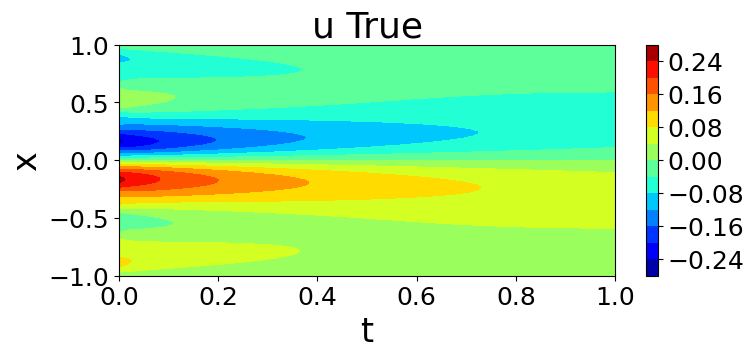

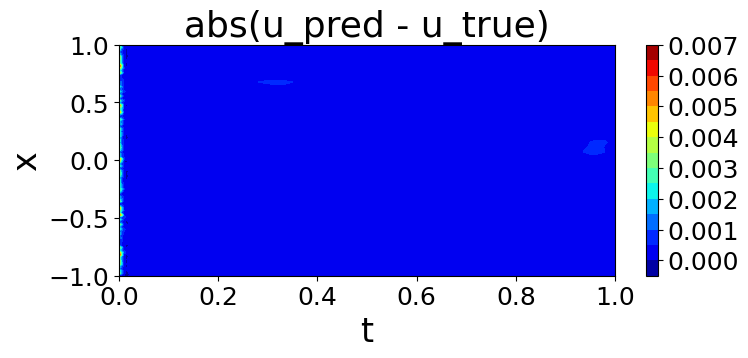

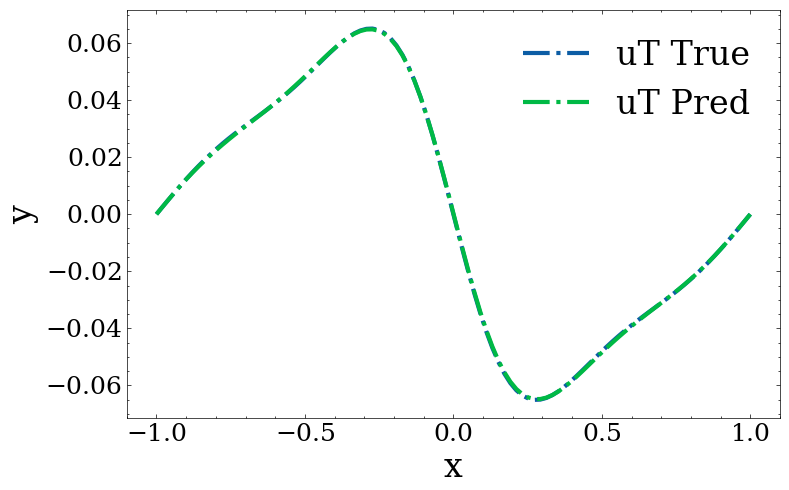

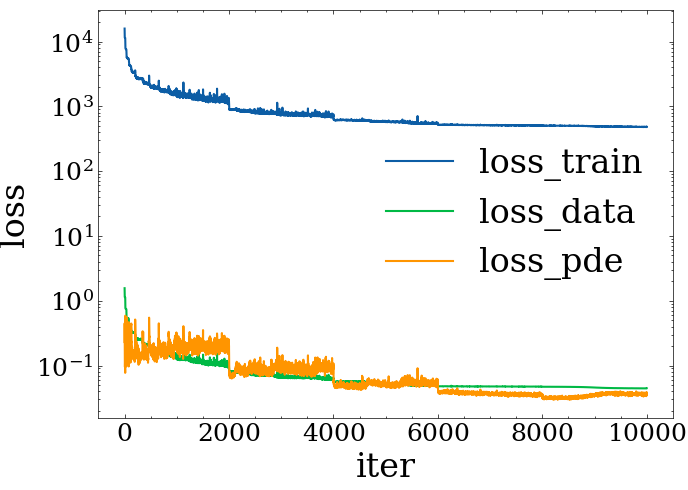

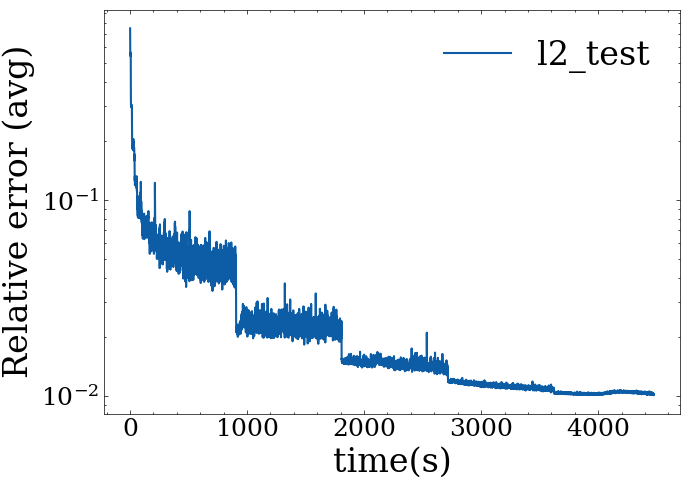

In [4]:
# #####################################
# # Load the trained model
# #####################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/DGNO_latent{beta_size}/', name=f'model_dgno_besterror')

########## The prediction of u(x,t)
with torch.no_grad():
    beta_pred = model_trained['enc'](a_test.to(device))
    xt_test = gridxt_test.repeat(u_test.shape[0], 1, 1).to(device)
    #
    u_pred = model_trained['u'](xt_test, beta_pred)
    u_pred = mollifer()(u_pred, xt_test).detach().cpu()
print('The test l2 error for u (avg):', solver.getError(u_pred, u_test))

# # # ########################################
from Utils.PlotFigure import Plot
inx = 0
Plot.show_1dt(gridxt_test, u_pred[inx], title='u True', tT=1.)
Plot.show_1dt(gridxt_test, torch.abs(u_pred[inx]-u_test[inx]), title='abs(u_pred - u_true)', tT=1.)
Plot.show_1d_list(x_test[inx], [uT_test[inx], uT_pred[inx]], ['uT True', 'uT Pred'], lb=-1.)
# #############################################
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/DGNO_latent{beta_size}/', name='loss_dgno')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_data'], loss_saved['loss_pde']], 
               ['loss_train', 'loss_data', 'loss_pde'])
# show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['error']], ['l2_test'])